<a href="https://colab.research.google.com/github/danieleinar/Mynstursgreining---Lokaverkefni/blob/main/mynstur_lokaverkefni_tjalfun.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install chess

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.4/154.4 kB 3.1 MB/s eta 0:00:00


In [2]:
import chess
import chess.syzygy
import numpy as np

In [3]:
from google.colab import drive
drive.mount('/content/drive')
%cd 'drive/My Drive/Colab Notebooks'

Mounted at /content/drive
/content/drive/My Drive/Colab Notebooks


In [4]:
tablebase = chess.syzygy.Tablebase()
tablebase.add_directory('Tablebase')

6

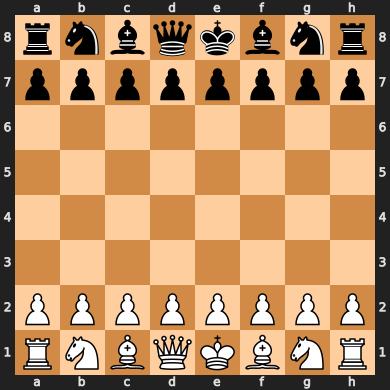

In [5]:
board = chess.Board()
board

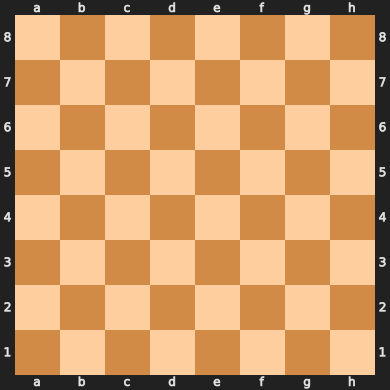

In [6]:
board.clear()
board

Ég bý til 10 þúsund random gagnapunkta. Til þess þurfti 14070 tilraunir því 4070 stöður voru ólöglegar. Hvítur getur unnið í 6643 af þessum 10 þúsund stöðum.

In [7]:
N = 10000
innmerki = np.zeros((N, 8), dtype=int)
sigur = np.zeros(N, dtype=int)
einkunn = np.zeros(N)

n = 0
teljari = 0
np.random.seed(37)

while n < N:
  reitir = np.random.choice(64, size=4, replace=False)
  teljari += 1
  board.clear()
  board.set_piece_at(reitir[0], chess.Piece(6, 1))  # Hvítur kóngur
  board.set_piece_at(reitir[1], chess.Piece(5, 1))  # Hvít drottning
  board.set_piece_at(reitir[2], chess.Piece(6, 0))  # Svartur kóngur
  board.set_piece_at(reitir[3], chess.Piece(4, 0))  # Svartur hrókur
  board.push(chess.Move.null())                     # Svartur á að leika
  if board.is_valid() and not board.is_checkmate():
    innmerki[n, 0] = chess.square_file(reitir[0])
    innmerki[n, 1] = chess.square_rank(reitir[0])
    innmerki[n, 2] = chess.square_file(reitir[1])
    innmerki[n, 3] = chess.square_rank(reitir[1])
    innmerki[n, 4] = chess.square_file(reitir[2])
    innmerki[n, 5] = chess.square_rank(reitir[2])
    innmerki[n, 6] = chess.square_file(reitir[3])
    innmerki[n, 7] = chess.square_rank(reitir[3])
    dtz = tablebase.probe_dtz(board)
    sigur[n] = (dtz < 0) * 1
    einkunn[n] = dtz / (-2.)
    n += 1

print(teljari)
print(np.sum(sigur))

14070
6643


Kerfin sem eiga að meta einkunn nota bara stöður þar sem hvítur getur unnið, svo hér bý ég til gögn sem hafa bara þær stöður.

In [9]:
fjoldi_sigra = np.sum(sigur)
innmerki_w = np.zeros((fjoldi_sigra, 8), dtype=int)
einkunn_w = np.zeros(fjoldi_sigra)

stak = 0

for n in range(N):
  if sigur[n] == 1:
    innmerki_w[stak] = innmerki[n]
    einkunn_w[stak] = einkunn[n]
    stak += 1

Tíðni hverrar einkunnar:

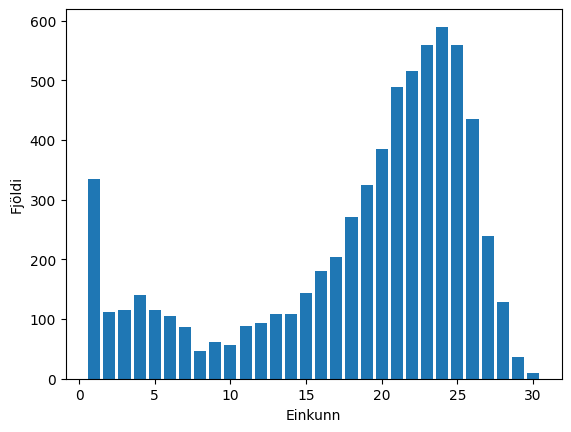

In [10]:
import matplotlib.pyplot as plt
plt.bar(*np.unique(einkunn_w, return_counts=True))
plt.xlabel('Einkunn')
plt.ylabel('Fjöldi')
plt.show()

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as MSE

80% gagnanna verða notuð fyrir þjálfun og 20% fyrir validation.

In [ ]:
inn_tr, inn_val, sigur_tr, sigur_val = train_test_split(innmerki, sigur, test_size=0.2, random_state=37)
inn_w_tr, inn_w_val, eink_w_tr, eink_w_val = train_test_split(innmerki_w, einkunn_w, test_size=0.2, random_state=37)

In [ ]:
print(inn_tr.shape)
print(inn_val.shape)
print(sigur_tr.shape)
print(sigur_val.shape)
print(inn_w_tr.shape)
print(inn_w_val.shape)
print(eink_w_tr.shape)
print(eink_w_val.shape)

(8000, 8)
(2000, 8)
(8000,)
(2000,)
(5314, 8)
(1329, 8)
(5314,)
(1329,)


Tvíundagreining

In [ ]:
flokkun_log = LogisticRegression(class_weight='balanced')
flokkun_log.fit(inn_tr, sigur_tr)

In [ ]:
print(flokkun_log.n_features_in_)
print(flokkun_log.classes_)
print(flokkun_log.intercept_)
print(flokkun_log.coef_)

8
[0 1]
[-0.16728192]
[[ 0.00199909  0.01912962  0.00923634 -0.01547337 -0.00474857 -0.00833787
   0.01847813  0.02846008]]


In [ ]:
flokkunarnakvaemni_log_tr = flokkun_log.score(inn_tr, sigur_tr)
print(flokkunarnakvaemni_log_tr)
flokkunarnakvaemni_log_val = flokkun_log.score(inn_val, sigur_val)
print(flokkunarnakvaemni_log_val)

0.5165
0.5075


Línuleg aðhvarfsgreining

In [ ]:
model_lin = LinearRegression()
model_lin.fit(inn_w_tr, eink_w_tr)

In [ ]:
print(model_lin.n_features_in_)
print(model_lin.intercept_)
print(model_lin.coef_)

8
18.198108685189705
[ 0.07601342 -0.01422038 -0.0391621  -0.02946407  0.00875522  0.02988318
  0.07781129 -0.04362035]


In [ ]:
skor_lin_tr = model_lin.score(inn_w_tr, eink_w_tr)
print(skor_lin_tr)
skor_lin_val = model_lin.score(inn_w_val, eink_w_val)
print(skor_lin_val)

0.0015131920167604784
-0.0014412598773134722


In [ ]:
mse_lin_tr = MSE(eink_w_tr, model_lin.predict(inn_w_tr))
print(mse_lin_tr)
mse_lin_val = MSE(eink_w_val, model_lin.predict(inn_w_val))
print(mse_lin_val)

58.63894059233847
61.150034593021736


Fyrir sum kerfin nota ég sköluð innmerki.

In [ ]:
inn_tr_skalad = inn_tr / 3.5 - 1.0
inn_val_skalad = inn_val / 3.5 - 1.0
inn_w_tr_skalad = inn_w_tr / 3.5 - 1.0
inn_w_val_skalad = inn_w_val / 3.5 - 1.0

In [ ]:
from sklearn.svm import SVC
from sklearn.svm import SVR

Stoðvigravélar - flokkun

In [ ]:
flokkun_svm = SVC(class_weight='balanced', random_state=42)
flokkun_svm.fit(inn_tr_skalad, sigur_tr)

In [ ]:
print(flokkun_svm.n_features_in_)
print(flokkun_svm.classes_)
print(flokkun_svm.n_iter_)

8
[0 1]
[10150]


In [ ]:
flokkunarnakvaemni_svm_tr = flokkun_svm.score(inn_tr_skalad, sigur_tr)
print(flokkunarnakvaemni_svm_tr)
flokkunarnakvaemni_svm_val = flokkun_svm.score(inn_val_skalad, sigur_val)
print(flokkunarnakvaemni_svm_val)

0.671375
0.6385


Stoðvigravélar - aðhvarfsgreining

In [ ]:
model_svm = SVR()
model_svm.fit(inn_w_tr_skalad, eink_w_tr)

In [ ]:
print(model_svm.n_features_in_)
print(model_svm.n_iter_)

8
4443


In [ ]:
skor_svm_tr = model_svm.score(inn_w_tr_skalad, eink_w_tr)
print(skor_svm_tr)
skor_svm_val = model_svm.score(inn_w_val_skalad, eink_w_val)
print(skor_svm_val)

0.29781846553967517
0.275934452004431


In [ ]:
mse_svm_tr = MSE(eink_w_tr, model_svm.predict(inn_w_tr_skalad))
print(mse_svm_tr)
mse_svm_val = MSE(eink_w_val, model_svm.predict(inn_w_val_skalad))
print(mse_svm_val)

41.237581663619956
44.21291101284224


In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor

Ákvörðunartré - flokkun

In [ ]:
flokkun_tree = DecisionTreeClassifier(class_weight='balanced', random_state=42, min_samples_leaf=3)
flokkun_tree.fit(inn_tr, sigur_tr)

In [ ]:
print(flokkun_tree.n_features_in_)
print(flokkun_tree.classes_)
print(flokkun_tree.max_features_)
print(flokkun_tree.get_depth())
print(flokkun_tree.get_n_leaves())

8
[0 1]
8
20
1520


In [ ]:
flokkunarnakvaemni_tree_tr = flokkun_tree.score(inn_tr, sigur_tr)
print(flokkunarnakvaemni_tree_tr)
flokkunarnakvaemni_tree_val = flokkun_tree.score(inn_val, sigur_val)
print(flokkunarnakvaemni_tree_val)

0.892
0.6745


Ákvörðunartré - aðhvarfsgreining

In [ ]:
model_tree = DecisionTreeRegressor(random_state=42, min_samples_leaf=10, max_depth=10, max_features=4)
model_tree.fit(inn_w_tr, eink_w_tr)

In [ ]:
print(model_tree.n_features_in_)
print(model_tree.max_features_)
print(model_tree.get_depth())
print(model_tree.get_n_leaves())

8
4
10
222


In [ ]:
skor_tree_tr = model_tree.score(inn_w_tr, eink_w_tr)
print(skor_tree_tr)
skor_tree_val = model_tree.score(inn_w_val, eink_w_val)
print(skor_tree_val)

0.37655456655626707
0.21658849553856574


In [ ]:
mse_tree_tr = MSE(eink_w_tr, model_tree.predict(inn_w_tr))
print(mse_tree_tr)
mse_tree_val = MSE(eink_w_val, model_tree.predict(inn_w_val))
print(mse_tree_val)

36.61358311594781
47.836695488517044


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor

Slembiskógur - flokkun

In [ ]:
flokkun_forest = RandomForestClassifier(class_weight='balanced', random_state=42, n_jobs=-1, bootstrap=True, n_estimators=150, min_samples_leaf=3, max_features=8)
flokkun_forest.fit(inn_tr, sigur_tr)

In [ ]:
print(flokkun_forest.n_features_in_)
print(flokkun_forest.classes_)

8
[0 1]


In [ ]:
flokkunarnakvaemni_forest_tr = flokkun_forest.score(inn_tr, sigur_tr)
print(flokkunarnakvaemni_forest_tr)
flokkunarnakvaemni_forest_val = flokkun_forest.score(inn_val, sigur_val)
print(flokkunarnakvaemni_forest_val)

0.994875
0.8055


Slembiskógur - aðhvarfsgreining

In [ ]:
model_forest = RandomForestRegressor(random_state=42, n_jobs=-1, bootstrap=True, n_estimators=200, min_samples_leaf=3, max_features=6)
model_forest.fit(inn_w_tr, eink_w_tr)

In [ ]:
print(model_forest.n_features_in_)

8


In [ ]:
skor_forest_tr = model_forest.score(inn_w_tr, eink_w_tr)
print(skor_forest_tr)
skor_forest_val = model_forest.score(inn_w_val, eink_w_val)
print(skor_forest_val)

0.7471087288550542
0.3986355289327249


In [ ]:
mse_forest_tr = MSE(eink_w_tr, model_forest.predict(inn_w_tr))
print(mse_forest_tr)
mse_forest_val = MSE(eink_w_val, model_forest.predict(inn_w_val))
print(mse_forest_val)

14.851749774182657
36.720534375908585


In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.neural_network import MLPRegressor

Tauganet með einu földu lagi (100 einingar) - flokkun

In [ ]:
flokkun_MLP = MLPClassifier(random_state=42, max_iter=400)
flokkun_MLP.fit(inn_tr_skalad, sigur_tr)

In [ ]:
print(flokkun_MLP.t_)
print(flokkun_MLP.n_features_in_)
print(flokkun_MLP.classes_)
print(flokkun_MLP.n_iter_)
print(flokkun_MLP.loss_)
print(flokkun_MLP.best_loss_)

3200000
8
[0 1]
400
0.23564292820219965
0.23507666996430018


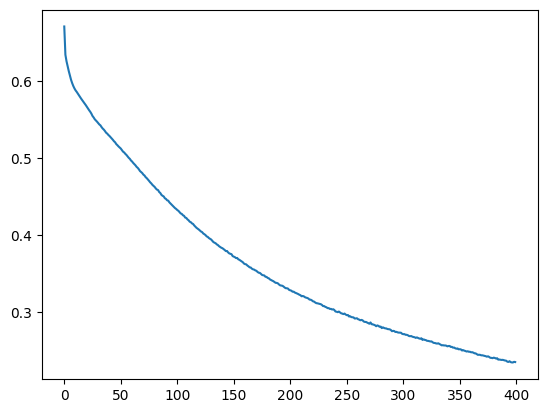

In [ ]:
import matplotlib.pyplot as plt
plt.plot(flokkun_MLP.loss_curve_)

In [ ]:
flokkunarnakvaemni_MLP_tr = flokkun_MLP.score(inn_tr_skalad, sigur_tr)
print(flokkunarnakvaemni_MLP_tr)
flokkunarnakvaemni_MLP_val = flokkun_MLP.score(inn_val_skalad, sigur_val)
print(flokkunarnakvaemni_MLP_val)

0.93575
0.917


Djúpt tauganet með fjórum földum lögum - flokkun

In [ ]:
flokkun_MLP_2 = MLPClassifier(random_state=42, max_iter=40, hidden_layer_sizes=(64, 64, 64, 64))
flokkun_MLP_2.fit(inn_tr_skalad, sigur_tr)

In [ ]:
print(flokkun_MLP_2.t_)
print(flokkun_MLP_2.n_features_in_)
print(flokkun_MLP_2.classes_)
print(flokkun_MLP_2.n_iter_)
print(flokkun_MLP_2.loss_)
print(flokkun_MLP_2.best_loss_)

320000
8
[0 1]
40
0.12341779007751334
0.12064445715660949


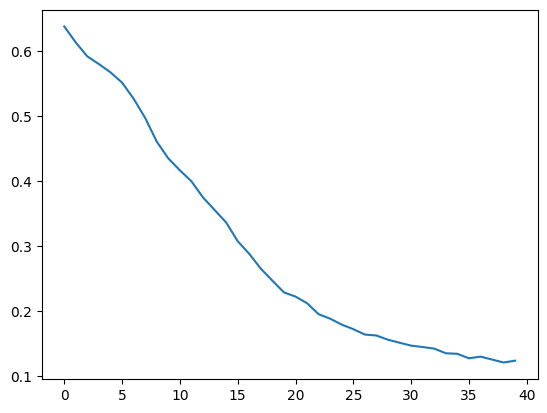

In [ ]:
plt.plot(flokkun_MLP_2.loss_curve_)

In [ ]:
flokkunarnakvaemni_MLP_2_tr = flokkun_MLP_2.score(inn_tr_skalad, sigur_tr)
print(flokkunarnakvaemni_MLP_2_tr)
flokkunarnakvaemni_MLP_2_val = flokkun_MLP_2.score(inn_val_skalad, sigur_val)
print(flokkunarnakvaemni_MLP_2_val)

0.959625
0.936


Tauganet með einu földi lagi (100 einingar) - aðhvarfsgreining

In [ ]:
model_MLP = MLPRegressor(random_state=42, max_iter=400, solver='sgd')
model_MLP.fit(inn_w_tr_skalad, eink_w_tr)

In [ ]:
print(model_MLP.t_)
print(model_MLP.n_features_in_)
print(model_MLP.n_iter_)
print(model_MLP.loss_)
print(model_MLP.best_loss_)

2125600
8
400
14.751496929427027
14.746303970229269


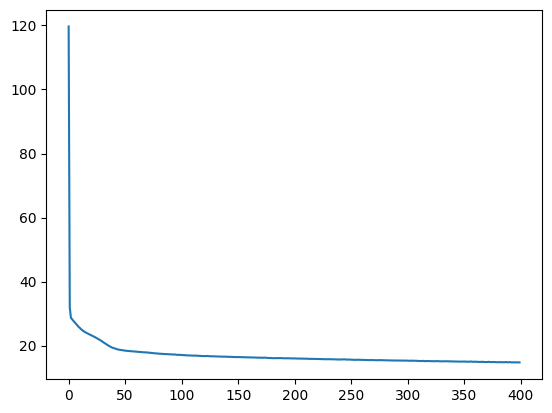

In [ ]:
plt.plot(model_MLP.loss_curve_)

In [ ]:
skor_MLP_tr = model_MLP.score(inn_w_tr_skalad, eink_w_tr)
print(skor_MLP_tr)
skor_MLP_val = model_MLP.score(inn_w_val_skalad, eink_w_val)
print(skor_MLP_val)

0.5025432150509452
0.4277260955803903


In [ ]:
mse_MLP_tr = MSE(eink_w_tr, model_MLP.predict(inn_w_tr_skalad))
print(mse_MLP_tr)
mse_MLP_val = MSE(eink_w_val, model_MLP.predict(inn_w_val_skalad))
print(mse_MLP_val)

29.214546077781502
34.94420537079722


Djúpt tauganet með þremur földum lögum - aðhvarfsgreining

In [ ]:
model_MLP_2 = MLPRegressor(random_state=42, max_iter=200, hidden_layer_sizes=(40, 40, 40), solver='adam')
model_MLP_2.fit(inn_w_tr_skalad, eink_w_tr)

In [ ]:
print(model_MLP_2.t_)
print(model_MLP_2.n_features_in_)
print(model_MLP_2.n_iter_)
print(model_MLP_2.loss_)
print(model_MLP_2.best_loss_)

1062800
8
200
15.438808220379238
15.417873412817897


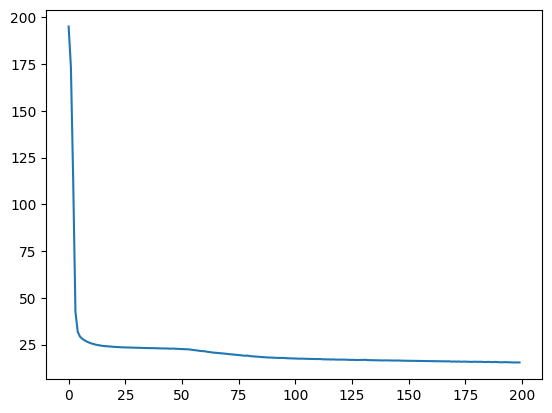

In [ ]:
plt.plot(model_MLP_2.loss_curve_)

In [ ]:
skor_MLP_2_tr = model_MLP_2.score(inn_w_tr_skalad, eink_w_tr)
print(skor_MLP_2_tr)
skor_MLP_2_val = model_MLP_2.score(inn_w_val_skalad, eink_w_val)
print(skor_MLP_2_val)

0.4808869494013437
0.38802930433235994


In [ ]:
mse_MLP_2_tr = MSE(eink_w_tr, model_MLP_2.predict(inn_w_tr_skalad))
print(mse_MLP_2_tr)
mse_MLP_2_val = MSE(eink_w_val, model_MLP_2.predict(inn_w_val_skalad))
print(mse_MLP_2_val)

30.486371068082423
37.36817196305287
